In [1]:
# Based on instant-NGP: https://nvlabs.github.io/instant-ngp/
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from math import *
import time
from IPython import display

from PIL import Image
from scipy.special import sph_harm
from scipy.spatial.transform import Rotation as R

DEVICE = "cuda"

## Read COLMAP data

In [2]:
# Use LLFF imgs2poses.py to produce this file...
# https://github.com/Fyusion/LLFF

poses = np.load("/sata/data/nerf/bottle/poses_bounds.npy")
matrices = poses[:,:-2].reshape([-1,3,5]).transpose([1,2,0])
rotations = matrices[:3,:3,:].transpose(2,0,1)
positions = matrices[:3,3,:].transpose(1,0)
up = -rotations[:,:,0]
right = rotations[:,:,1]
forward = -rotations[:,:,2]

min_pos = np.min(positions[:,:3],axis=0)
max_pos = np.max(positions[:,:3],axis=0)

max_L = np.max(max_pos-min_pos)

positions[:,:3] -= min_pos
positions[:,:3] /= max_L

positions = 0.8*(positions-0.5)+0.5

In [3]:
focal_length = matrices[2,4,0]
halfwidth = 1080/2

horizontal_fov = 2*atan(halfwidth / focal_length)*(180/pi)

print(horizontal_fov)

30.1347807706884


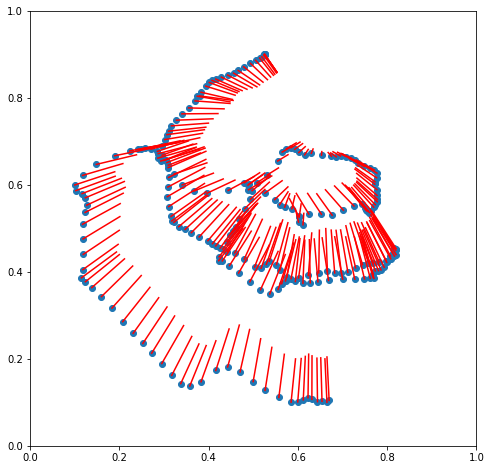

In [4]:
colors = ['r', 'g', 'b']

for i in range(positions.shape[0]):
    for j in range(1):
        plt.plot([positions[i,0], positions[i,0] + forward[i,0]*0.1], 
                 [positions[i,2], positions[i,2] + forward[i,2]*0.1], colors[j])
plt.scatter(positions[:,0], positions[:,2])
plt.xlim(0,1)
plt.ylim(0,1)
plt.gcf().set_size_inches((8,8))
plt.show()

In [5]:
camera_mean = np.mean(positions,axis=0)
camera_std = np.sqrt(np.sum(np.std(positions,axis=0)**2))

In [6]:
camera_mean

array([0.51043826, 0.3435619 , 0.5203553 ])

In [7]:
camera_std

0.31491011020722526

## NeRF

In [11]:
# Linear interpolation
#
# u = x-floor(x)
# v = y-floor(y)
# u*v*psi[x+1,y+1] + (1-u)*v*psi[x,y+1] + u*(1-v)*psi[x+1,y] + (1-u)*(1-v)*psi[x,y]

MIN_DIST = 0.05

class HashTable(nn.Module):
    def __init__(self, T = 2**19, scale0 = 16, scale1 = 2048, L = 12, d=2):
        super().__init__()
        self.L = L
        self.T = T
        self.scale0 = scale0
        self.scale1 = scale1
        self.d = d        
        self.primes = [1, 2654435761, 805459861]
        self.hashtable = nn.Parameter(torch.randn(T,2)*1e-4)
        
    def hash(self, x): # x is batch x dim
        z = torch.zeros(x.shape[0]).to(DEVICE).long()
        
        for d in range(self.d):
            zi = x[:,d].long() * int(self.primes[d])
            z = torch.bitwise_xor(z, zi)
        return self.hashtable[z%self.T]
    
    def forward(self, x): # x is batch x dim: [0..1]
        features = []
        ws = []
        coords = []
        for l in range(self.L):
            b = exp(log(self.scale0)*(1-(l/(self.L-1))) + log(self.scale1)*(l/(self.L-1)))
            
            coord = x*b
            
            #coord_vals = []
            #coord_w = []
            val = 0
            lcoords = []
            lws = []
            for cidx in range(1):#2**self.d):
                w = torch.ones_like(coord[:,0])
                icoord = coord.detach().clone()
                
                """
                for d in range(self.d):
                    bit = (cidx // (2**d))%2
                    
                    if bit:
                        w *= (coord[:,d]-torch.floor(icoord[:,d]))
                        icoord[:,d] = torch.ceil(icoord[:,d])+1e-4
                    else:
                        w *= 1-(coord[:,d]-torch.floor(icoord[:,d]))
                        icoord[:,d] = torch.floor(icoord[:,d])
                """
                
                icoord = icoord.long()
                lcoords.append(icoord.unsqueeze(1))
                lws.append(w.unsqueeze(1).detach())
                #val += w.unsqueeze(1)*self.hash(icoord)
            coords.append(torch.cat(lcoords,1).unsqueeze(2))
            ws.append(torch.cat(lws,1).unsqueeze(2))
            #features.append(val) # batch x 2
        coords = torch.cat(coords,2)
        ws = torch.cat(ws,2)
        
        N = coords.shape[0]
        M = coords.shape[1]
        L = coords.shape[2]
        features = torch.sum(ws.unsqueeze(3)*self.hash(coords.view(N*M*L, self.d)).view(N,M,L,2),1).view(N,2*L)
        return features

class DensityNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(24, 64)
        self.l2 = nn.Linear(64, 1, bias=None)
        
    def forward(self, x):
        z = torch.relu(self.l1(x))
        z = self.l2(z)
        
        density = torch.exp(torch.clamp(z[:,0]-2,-20,20))
        
        return density, z

class RGBNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(40, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 3)
        
    def forward(self, x):
        z = torch.relu(self.l1(x))
        z = torch.relu(self.l2(z))
        z = torch.sigmoid(self.l3(z))
        
        return z

class BackgroundNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(24, 64)
        self.l3 = nn.Linear(64, 3)
        
    def forward(self, x):
        z = torch.relu(self.l1(x))
        z = torch.sigmoid(self.l3(z))
        
        return z

class NeRFNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hashtable = HashTable(d=3)        
        self.bghash = HashTable(d=2)
        
        self.density = DensityNet()
        self.rgb = RGBNet()
        self.background = BackgroundNet()
        
        self.optim = torch.optim.Adam(self.parameters(), betas=[0.9, 0.99], eps=1e-15, lr=1e-2)

    def forward(self, x, harmonics):
        features = self.hashtable(x)
        
        rho, z = self.density(features)
        rgb = self.rgb(torch.cat([features, harmonics], 1))
        
        return rho, rgb

class Renderer():
    def __init__(self):
        pass
    
    def get_ray_batch(self, camera_position, forward, up, right, res):
        fov = horizontal_fov
        horiz = res[1]
        
        yy,xx = np.meshgrid((np.arange(res[1])-res[1]/2)/horiz, (np.arange(res[0])-res[0]/2)/horiz)
        zz = torch.FloatTensor(np.concatenate([xx.ravel()[:,np.newaxis], yy.ravel()[:,np.newaxis]], axis=1)).to(DEVICE)
        sin_zz = torch.sin(zz*fov*pi/180.0)
        cos_zz = torch.cos(zz*fov*pi/180.0)
        
        ray_dir = torch.nn.functional.normalize(forward.unsqueeze(0)*cos_zz[:,1:2]*cos_zz[:,0:1] + \
                                                right.unsqueeze(0)*sin_zz[:,1:2]*cos_zz[:,0:1] - \
                                                up.unsqueeze(0)*sin_zz[:,0:1], dim=1)
        
        ray_dir_np = ray_dir.cpu().detach().numpy()
        
        harmonics = []
        
        phi = np.arctan2(ray_dir_np[:,2], np.sqrt(ray_dir_np[:,0]**2 + ray_dir_np[:,1]**2))
        theta = np.arctan2(ray_dir_np[:,1], ray_dir_np[:,0])
        
        for n in range(0,4):
            for m in range(-n, n+1):
                harmonics.append(np.real(sph_harm(m, n, theta, phi)))
        
        harmonics = torch.FloatTensor(np.array(harmonics).transpose(1,0)).to(DEVICE)
        
        return camera_position.view(1,3).expand(ray_dir.shape[0], 3), ray_dir, harmonics

    def get_pixel_color(self, ray_pos, ray_dir, harmonics, net, stepsize=0.005, max_steps=150, bg=False, clip=False):
        density_loss = 0
        
        phi = torch.atan2(ray_dir[:,2], torch.sqrt(ray_dir[:,0]**2 + ray_dir[:,1]**2))
        theta = torch.atan2(ray_dir[:,1], ray_dir[:,0])
        
        bgfeat = net.bghash(torch.cat([phi.unsqueeze(1), theta.unsqueeze(1)], 1))
        if bg:
            bgcol = net.background(bgfeat)
        
        all_pos = ray_pos.unsqueeze(0) + ray_dir.unsqueeze(0) * (MIN_DIST + stepsize * torch.arange(max_steps).to(DEVICE).view(max_steps, 1, 1))
        
        N = all_pos.shape[0]
        M = all_pos.shape[1]
        
        all_pos = all_pos.view(N*M, 3)
        harmonics = harmonics.unsqueeze(0).expand(N,M,16).contiguous().view(N*M,16)
        
        rho, rgb = net.forward(all_pos, harmonics)
        if clip:
            rho -= 5
            rho = rho*torch.le(torch.sum( (all_pos-torch.cuda.FloatTensor(camera_mean).unsqueeze(0))**2, 1), 4 * camera_std**2).float()
        rho = torch.log(1-torch.clamp(stepsize * rho.view(N,M,1),0,0.9999))
        rgb = rgb.view(N,M,3)
        
        weight = torch.exp(torch.clamp(torch.cumsum(rho,0), -20, 0))
        color = torch.sum(-rgb[:-1]*(weight[1:]-weight[:-1]), 0)
        if bg:
            color = color + weight[-1] * bgcol
        
        return color

## NeRF

In [12]:
nerf = NeRFNet().to(DEVICE)
#nerf.load_state_dict(torch.load("nerf_bottle.pth"))
render = Renderer()

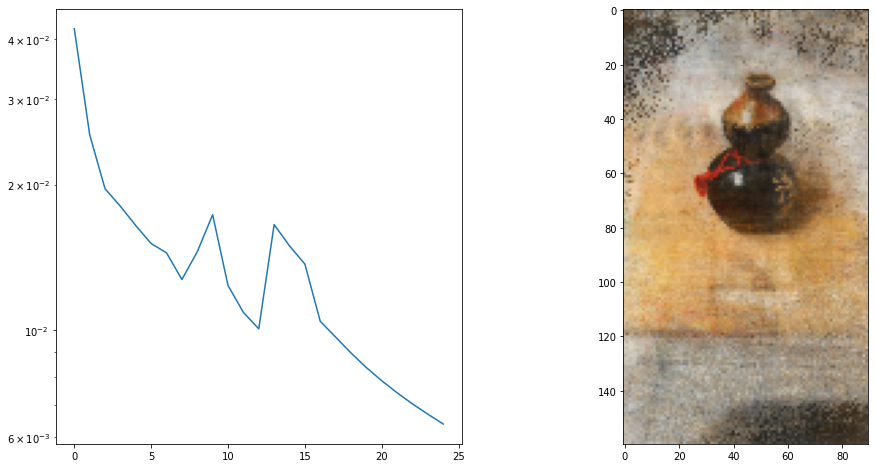

1.1571319103240967
1.1498017311096191
1.1509521007537842
1.1533372402191162
1.1469619274139404
1.1485517024993896
1.1728923320770264
1.2650425434112549
1.266469955444336
1.2086873054504395
1.2372286319732666
1.1197926998138428
1.1222670078277588
1.0975520610809326
1.237114429473877
1.2987885475158691
1.1943092346191406
1.137024164199829
1.167579174041748
1.2554948329925537
1.2712359428405762
1.2364940643310547
1.156783103942871
1.105196475982666
1.1152980327606201
1.2125272750854492
1.2502689361572266
1.2760937213897705
1.152984857559204
1.1509649753570557
1.163832664489746
1.1397745609283447
1.1448047161102295
1.1219518184661865
1.138843059539795
1.1384873390197754
1.1316158771514893
1.1537179946899414
1.1350650787353516
1.1143732070922852
1.1450016498565674
1.1335389614105225
1.1077961921691895
1.0997202396392822
1.1491422653198242
1.1422171592712402
1.1525506973266602
1.1316132545471191
1.2344465255737305
1.2393975257873535
1.2179310321807861
1.1990258693695068
1.1622049808502197
1.

KeyboardInterrupt: 

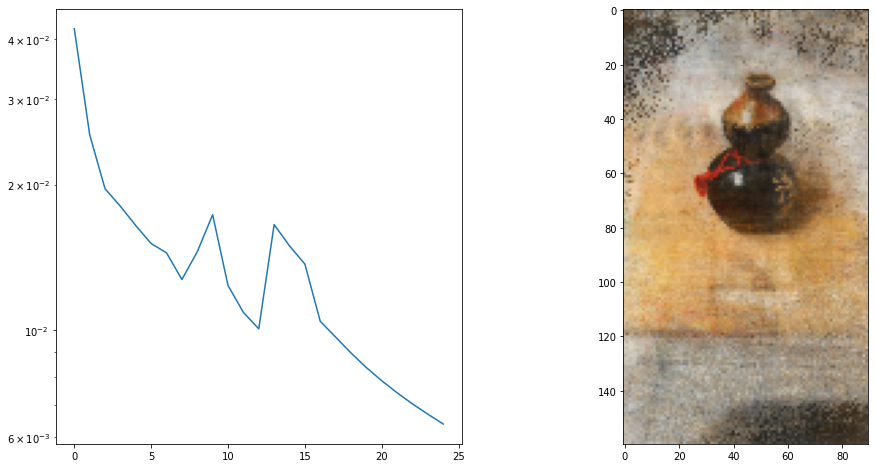

In [26]:
for p in nerf.optim.param_groups:
    p['lr'] = 1e-3
BS = 3600
#tr_err = []

for epoch in range(100000):
    
    errs = []
    for b in range(235):
        t1 = time.time()
        nerf.optim.zero_grad()
        frame = b
        im = np.array(Image.open("/sata/data/nerf/bottle/images/%.4d.png" % (frame+1)))[::12,::12,:3]/256.0
        XR = im.shape[0]
        YR = im.shape[1]
        im = torch.FloatTensor(im).to(DEVICE)
        
        campos = torch.FloatTensor(positions[frame]).to(DEVICE)
        campos = campos + torch.randn_like(campos)*0.0001
        
        with torch.no_grad():
            raypos, raydir, harmonics = render.get_ray_batch(campos, torch.FloatTensor(forward[frame]).to(DEVICE),
                                       torch.FloatTensor(up[frame]).to(DEVICE),
                                       torch.FloatTensor(right[frame]).to(DEVICE), [im.shape[0], im.shape[1]])
        im = im.view(im.shape[0]*im.shape[1],3)
        for b2 in range(raypos.shape[0]//BS):
            p = render.get_pixel_color(raypos[b2*BS:b2*BS+BS], 
                                       raydir[b2*BS:b2*BS+BS], 
                                       harmonics[b2*BS:b2*BS+BS], nerf, bg=True, stepsize = 0.00125, max_steps = 600)
            loss = torch.mean((im[b2*BS:b2*BS+BS]-p)**2) #+ 1e-2 * dloss
            loss.backward()
            errs.append(loss.cpu().detach().item())
    
        nerf.optim.step()
        t2 = time.time()
        
        print(t2-t1)
    
    tr_err.append(np.mean(errs))
    
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(tr_err)
    plt.yscale("log")
    
    plt.subplot(1,2,2)
    
    with torch.no_grad():
        p = np.zeros((0,3))

        campos = torch.FloatTensor(positions[frame]).to(DEVICE)
        campos = campos + torch.randn_like(campos)*0.0001

        raypos, raydir, harmonics = render.get_ray_batch(campos, torch.FloatTensor(forward[frame]).to(DEVICE),
                                   torch.FloatTensor(up[frame]).to(DEVICE),
                                   torch.FloatTensor(right[frame]).to(DEVICE), [XR, YR])

        for b2 in range(raypos.shape[0]//BS):
            partial = render.get_pixel_color(raypos[b2*BS:b2*BS+BS], 
                                             raydir[b2*BS:b2*BS+BS], 
                                             harmonics[b2*BS:b2*BS+BS], 
                                             nerf, bg=True, stepsize = 0.00125, max_steps = 600)
            partial = np.clip(partial.cpu().detach().numpy(),0,1)
            p = np.concatenate([p,partial], axis=0)

    plt.imshow(p.reshape((XR,YR,3)))
    
#    plt.subplot(1,3,3)
#    im = np.clip(im.cpu().detach().numpy(),0,1)
#    plt.imshow(im)
    
    plt.gcf().set_size_inches((16,8))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)    

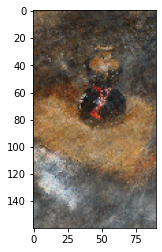

In [28]:
frame = 210
BS = 3600

with torch.no_grad():
    p = np.zeros((0,3))

    campos = torch.FloatTensor(positions[frame]).to(DEVICE)
    campos = campos + torch.randn_like(campos)*0.001

    raypos, raydir, harmonics = render.get_ray_batch(campos, torch.FloatTensor(forward[frame]).to(DEVICE),
                               torch.FloatTensor(up[frame]).to(DEVICE),
                               torch.FloatTensor(right[frame]).to(DEVICE), [160, 90])

    for b2 in range(raypos.shape[0]//BS):
        partial = render.get_pixel_color(raypos[b2*BS:b2*BS+BS], raydir[b2*BS:b2*BS+BS], harmonics[b2*BS:b2*BS+BS], nerf, bg=False)
        partial = np.clip(partial.cpu().detach().numpy(),0,1)
        p = np.concatenate([p,partial], axis=0)

plt.imshow(p.reshape((160,90,3)))


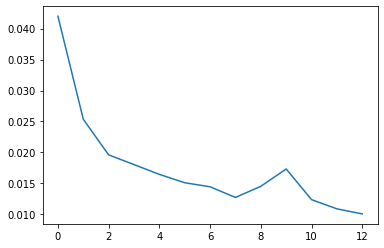

In [20]:
plt.plot(tr_err)

In [12]:
tr_err

[0.009349676397966201]

In [10]:
raydir.shape

torch.Size([14400, 3])

In [29]:
torch.save(nerf.state_dict(), open("nerf_bottle2.pth","wb"))

In [31]:
# https://www.openvdb.org/documentation/doxygen/python.html

import pyopenvdb as vdb

camera_mean = positions[0] + 0.5 * forward[0]

xx,yy,zz = np.meshgrid(np.arange(256), np.arange(256), np.arange(256))
vox = np.concatenate([xx.ravel()[:,np.newaxis], yy.ravel()[:, np.newaxis], zz.ravel()[:, np.newaxis]], axis=1)/128.0-1
vox = 0.25 * vox + camera_mean

density = vdb.FloatGrid()
density.name = 'density'

color= vdb.Vec3SGrid()
color.name = 'color'

BS = 256*256

with torch.no_grad():
    t1 = time.time()
    
    allrho = np.zeros((0,))
    rgbvals = np.zeros((0,3))
    
    for b in range(vox.shape[0]//BS):
        cvox = torch.cuda.FloatTensor(vox[b*BS:b*BS+BS])
        features = nerf.hashtable(cvox)
        t2 = time.time()
        rho, z = nerf.density(features)
        rho = rho*torch.le(torch.sum( (cvox-torch.cuda.FloatTensor(camera_mean).unsqueeze(0))**2, 1), 4 * camera_std**2).float()
        
        rgb = nerf.rgb(torch.cat([features, torch.zeros(features.shape[0], 16).cuda()],1))
        t3 = time.time()
        allrho = np.concatenate([allrho, rho.cpu().detach().numpy()], axis=0)
        rgbvals = np.concatenate([rgbvals, rgb.cpu().detach().numpy()], axis=0)
    
        print(t2-t1, t3-t2)

0.007314205169677734 0.0015759468078613281
0.01230764389038086 0.0013685226440429688
0.01709580421447754 0.0013666152954101562
0.02191758155822754 0.001352071762084961
0.027065753936767578 0.0013740062713623047
0.032494306564331055 0.0013620853424072266
0.03797340393066406 0.0013644695281982422
0.0436549186706543 0.001352548599243164
0.05024981498718262 0.0013573169708251953
0.05740475654602051 0.0015478134155273438
0.06353974342346191 0.001352071762084961
0.06986212730407715 0.0014753341674804688
0.07625555992126465 0.0013599395751953125
0.08355236053466797 0.0013458728790283203
0.09004092216491699 0.0013570785522460938
0.09788155555725098 0.0013680458068847656
0.10471391677856445 0.0013692378997802734
0.11259794235229492 0.0013523101806640625
0.11978530883789062 0.0013713836669921875
0.12867140769958496 0.0013904571533203125
0.13605737686157227 0.0015511512756347656
0.14708161354064941 0.0018839836120605469
0.16325974464416504 0.0015981197357177734
0.1758744716644287 0.00138115882873

8.842504978179932 0.0016028881072998047
8.93254041671753 0.010525226593017578
9.011859893798828 0.0013797283172607422
9.08224105834961 0.0013775825500488281
9.15667986869812 0.0013887882232666016
9.238882541656494 0.0013856887817382812
9.309756517410278 0.001382589340209961
9.383773803710938 0.0013835430145263672
9.459702014923096 0.001390695571899414
9.555570125579834 0.01063847541809082
9.644132852554321 0.0014820098876953125
9.720412969589233 0.0013852119445800781
9.812480449676514 0.0014028549194335938
9.888582944869995 0.0014157295227050781
9.962778806686401 0.0013854503631591797
10.047300100326538 0.00139617919921875
10.122951745986938 0.0013744831085205078
10.208929061889648 0.0013933181762695312
10.284207820892334 0.0013921260833740234
10.360726594924927 0.0013930797576904297
10.445537567138672 0.0014238357543945312
10.527527093887329 0.0013802051544189453
10.618165254592896 0.0013990402221679688
10.694036483764648 0.0013768672943115234
10.791356801986694 0.0013837814331054688


In [32]:
rho = np.clip(0.005*allrho.reshape((256,256,256))-0.1,0,1)
rgbvals = rgbvals.reshape((256,256,256,3))
density.copyFromArray(rho)
color.copyFromArray(rgbvals)
    
vdb.write('mygrids.vdb', grids=[density, color])

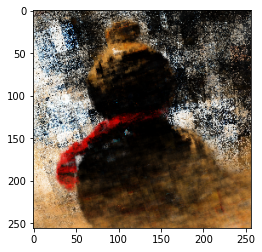

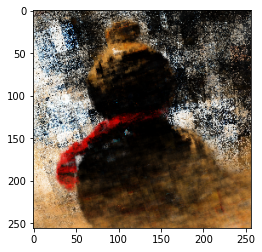

In [30]:
!mkdir output
!rm output/*.png

BS = 4096

with torch.no_grad():
    for frame in range(150):
        campos = torch.cuda.FloatTensor(positions[0] + frame*forward[0]/150.0 - 0.2*forward[0] + 0.12*right[0])
        target = torch.cuda.FloatTensor(positions[0] + 0.4*forward[0] - 0.02*right[0])
        f = F.normalize(target-campos,dim=0)
        u = torch.cuda.FloatTensor(up[0])
        r = torch.cross(f,u,dim=0)

        raypos, raydir, harmonics = render.get_ray_batch(campos, f, u, r, [256, 256])

        p = np.zeros((0,3))

        for b2 in range(raypos.shape[0]//BS):
            partial = render.get_pixel_color(raypos[b2*BS:b2*BS+BS], raydir[b2*BS:b2*BS+BS], harmonics[b2*BS:b2*BS+BS], nerf, stepsize = 0.001, max_steps=600, bg=True, clip=True)
            partial = np.clip(partial.cpu().detach().numpy(),0,1)
            p = np.concatenate([p,partial], axis=0)

        p = np.clip(255*p.reshape((256, 256, 3)),0,255).astype(np.uint8)
        plt.clf()
        plt.imshow(p)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)    

        im = Image.fromarray(p)
        im.save("output/%.6d.png" % frame)


In [40]:
positions[0]

array([0.52526899, 0.14314485, 0.89985605])

In [41]:
forward[0]

array([ 0.27445833,  0.87166201, -0.40605167])

In [42]:
up[0]

array([ 0.24082611, -0.4711175 , -0.84855824])

In [43]:
right[0]

array([-0.93095403,  0.13510603, -0.3392211 ])